In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))
pd.options.display.max_columns = 999
conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
sql_query ="SELECT \
      [Period] \
      ,IIF([Month]=1,1,0) Jan \
      ,IIF([Month]=2,1,0) Feb \
      ,IIF([Month]=3,1,0) Mar \
      ,IIF([Month]=4,1,0) Apr \
      ,IIF([Month]=5,1,0) May \
      ,IIF([Month]=6,1,0) Jun \
      ,IIF([Month]=7,1,0) Jul \
      ,IIF([Month]=8,1,0) Aug \
      ,IIF([Month]=9,1,0) Sep \
      ,IIF([Month]=10,1,0) Okt \
      ,IIF([Month]=11,1,0) Nov \
      ,IIF([Month]=12,1,0) Dec \
      ,DateDiff(DAY, a.[PurchaseDate], Period)/30.0 FromLastP \
      ,DateDiff(DAY, a.[FirstVisit], Period)/30.0 FromFirstP \
      ,IIF((DateDiff(DAY, Period, a.[NEXTDate])>=0 and DateDiff(DAY, Period, a.[NEXTDate])<=31),1,0) VisitInCurrentMonth \
      ,IIF(a.[NEXTDate]>a.[PurchaseDate],1,0) BudetVisit \
      ,a.[PartnerID] \
      ,IIF(a.[Sex] = 'M',1,0) Sex \
      ,a.[CityID] \
      ,IIF(DATEDIFF(YEAR,a.[BirthDate],[Period])> 100 , 0 , DATEDIFF(YEAR,a.[BirthDate],[Period])) Age \
      ,[AVGFromLastPurchM]/30.0 [AVGFromLastPurchM] \
      ,a.[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,t.LastP \
      ,t.Dif \
  FROM [Gold585].[dbo].[PurchaseGrid] a \
  left join TempT t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  Where Period >= '20170101' and Period <= '20181230' \
  and t.LastP = 1 and Dif < 1100 \
  order by Period, a.[PurchaseDate]"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 36min 54s


In [3]:
df['ottok'] = df['FromLastP']>12

In [4]:
df.head()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,CityID,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,ottok
0,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2090545,0,117,38,NaN,1,0,1,8136.0,8136.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1099,True
1,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2093296,0,14,48,NaN,1,0,1,992.0,992.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1099,True
2,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2092696,1,66,46,NaN,1,0,1,6840.0,6840.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,True
3,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2093789,1,92,25,NaN,1,0,1,32680.0,32680.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,True
4,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2094082,0,30,25,NaN,1,0,1,3952.0,3952.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1099,True


In [5]:
df.tail()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,CityID,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,ottok
33003980,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,22.566666,0,0,3809325,1,78,52,15.066666,3,1,3,8401.00,4095.00,0,0,1,0,0,0,0,0,0,1,0,1,0,2,1,0,0,3,0,0,0,0,0,1,0,0,2,3,0,1,17,False
33003981,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,0.133333,0,0,6676951,0,92,79,NaN,1,0,1,8456.00,8456.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,17,False
33003982,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,30.733333,0,0,2548269,0,93,26,30.600000,2,0,2,5457.00,2728.50,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,17,False
33003983,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,17.500000,0,0,4201597,0,30,21,8.866666,3,0,4,6682.96,2314.48,0,2,0,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,1,1,1,1,0,4,0,0,0,4,0,1,17,False
33003984,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,0.133333,0,0,6678870,0,90,31,NaN,1,0,1,847.00,847.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,17,False


In [6]:
df.columns.values

array(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP',
       'VisitInCurrentMonth', 'BudetVisit', 'PartnerID', 'Sex', 'CityID',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'LastP', 'Dif', 'ottok'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33003985 entries, 0 to 33003984
Data columns (total 59 columns):
Period                 datetime64[ns]
Jan                    int64
Feb                    int64
Mar                    int64
Apr                    int64
May                    int64
Jun                    int64
Jul                    int64
Aug                    int64
Sep                    int64
Okt                    int64
Nov                    int64
Dec                    int64
FromLastP              float64
FromFirstP             float64
VisitInCurrentMonth    int64
BudetVisit             int64
PartnerID              int64
Sex                    int64
CityID                 int64
Age                    int64
AVGFromLastPurchM      float64
QNTVisits              int64
SumSMS                 int64
SumQuantity            int64
SumSumma               float64
AVGSumma               float64
SUMM1                  int64
SUMM2                  int64
SUMM3                  in

In [8]:
df[(df['Period']=='2018-07-01')&(df['ottok']==1)].shape

(1034697, 59)

In [9]:
df[(df['Period']=='2018-07-01')&(df['ottok']!=1)].shape

(929579, 59)

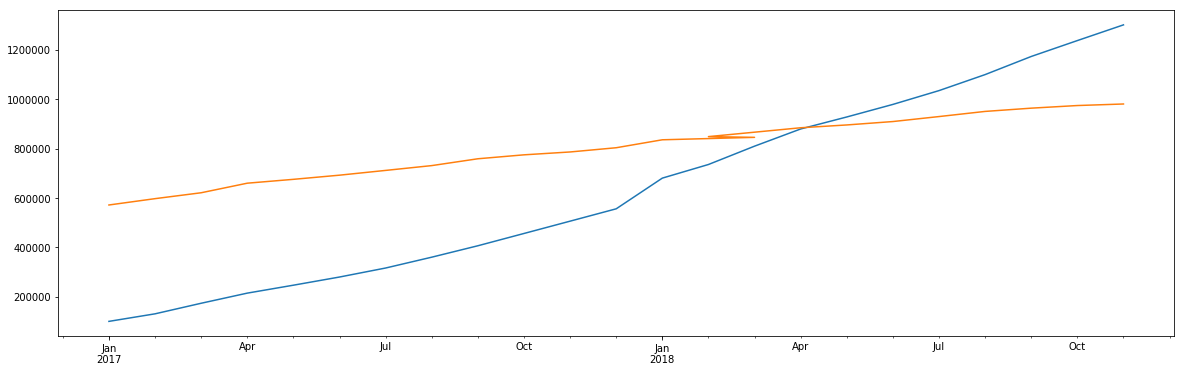

In [10]:
plt.figure(figsize=(20,6))
df[df['ottok']==1]['Period'].value_counts().plot()
df[df['ottok']!=1]['Period'].value_counts().plot()
# попадают только клиенты с количеством визитов > 1

In [11]:
#pred = df[df['Period']=='2018-11-01'].fillna(0).reset_index(drop=True)
#predId = pred['PartnerID']

In [12]:
#pred

In [13]:
#data = df[(df['Period']>='2017-01-01')].fillna(0).reset_index(drop=True)
df = df[(df['Period']<='2018-12-30')].fillna(0).reset_index(drop=True)
df.head()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,CityID,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,ottok
0,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2090545,0,117,38,0.0,1,0,1,8136.0,8136.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1099,True
1,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2093296,0,14,48,0.0,1,0,1,992.0,992.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1099,True
2,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2092696,1,66,46,0.0,1,0,1,6840.0,6840.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,True
3,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2093789,1,92,25,0.0,1,0,1,32680.0,32680.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,True
4,2017-01-01,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,0,0,2094082,0,30,25,0.0,1,0,1,3952.0,3952.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1099,True


In [14]:
df.tail()

,Period,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,CityID,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,ottok
33003980,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,22.566666,0,0,3809325,1,78,52,15.066666,3,1,3,8401.00,4095.00,0,0,1,0,0,0,0,0,0,1,0,1,0,2,1,0,0,3,0,0,0,0,0,1,0,0,2,3,0,1,17,False
33003981,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,0.133333,0,0,6676951,0,92,79,0.000000,1,0,1,8456.00,8456.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,17,False
33003982,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,30.733333,0,0,2548269,0,93,26,30.600000,2,0,2,5457.00,2728.50,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,17,False
33003983,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,17.500000,0,0,4201597,0,30,21,8.866666,3,0,4,6682.96,2314.48,0,2,0,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,1,1,1,1,0,4,0,0,0,4,0,1,17,False
33003984,2018-11-01,0,0,0,0,0,0,0,0,0,0,1,0,0.133333,0.133333,0,0,6678870,0,90,31,0.000000,1,0,1,847.00,847.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,17,False


In [15]:
df.columns.values

array(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP',
       'VisitInCurrentMonth', 'BudetVisit', 'PartnerID', 'Sex', 'CityID',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'LastP', 'Dif', 'ottok'], dtype=object)

In [16]:
#df['PoSMS'].value_counts()
df['ottok'].value_counts()

False    18399696
True     14604289
Name: ottok, dtype: int64

In [17]:
%%time
df = pd.get_dummies(df, columns = ['CityID'],drop_first=True)

Wall time: 1min 32s


In [18]:
%%time
train = df[(df['Period']<='2018-07-30') & (df['Period']>='2017-01-01')].fillna(0).reset_index(drop=True)
test1 = df[(df['Period']=='2018-08-01')].fillna(0).reset_index(drop=True)
test2 = df[(df['Period']=='2018-09-01')].fillna(0).reset_index(drop=True)
pred  = df[(df['Period']=='2018-11-01')].fillna(0).reset_index(drop=True)
predId= pred['PartnerID']

pred2  = df[(df['Period']=='2018-11-01')].fillna(0).reset_index(drop=True)

Wall time: 1min 36s


In [19]:
pred2  = df[(df['Period']=='2018-11-01')].fillna(0).reset_index(drop=True)

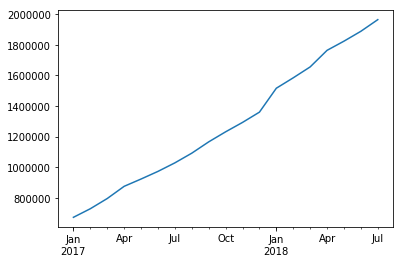

In [20]:
train['Period'].value_counts().plot()

In [21]:
#train = df[(df['Period']>='2017-11-30')].fillna(0).reset_index(drop=True)

In [22]:
train['ottok'].value_counts()

False    14530964
True      9793711
Name: ottok, dtype: int64

In [67]:
train.columns.values

array(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP',
       'VisitInCurrentMonth', 'PoSMS', 'BudetVisit', 'PartnerID', 'Sex',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'ottok', 'CityID_2', 'CityID_3',
       'CityID_4', 'CityID_5', 'CityID_6', 'CityID_7', 'CityID_9',
       'CityID_10', 'CityID_11', 'CityID_12', 'CityID_13', 'CityID_14',
       'CityID_15', 'CityID_16', 'CityID_17', 'CityID_18', 'CityID_19',
       'CityID_20', 'CityID_21', 'CityID_22', 'CityID_23', 'CityID_24',
       'CityID_25', 

In [23]:
def new_column2(data_frame):
    data_frame['Year']  = data_frame['Period'].dt.year  #train['Period'].apply(lambda x: x.year)
    data_frame['Month'] = data_frame['Period'].dt.month #train['Period'].apply(lambda x: x.month)
    data_frame['Day']   = data_frame['Period'].dt.day #train['Period'].apply(lambda x: x.day)

In [24]:
i=1
for table in (train,test1,test2,pred):
   # print(i)
    new_column2(table)
    i=i+1

In [25]:
y      = train['ottok']
#yv     = train['VisitInCurrentMonth']
#yottok = train['BudetVisit']
train  = train.drop(['Period','VisitInCurrentMonth','BudetVisit','ottok'],axis=1).reset_index(drop=True)
y1     = test1['ottok']
#yv1    = test1['VisitInCurrentMonth']
#yottok1= test1['BudetVisit']
test1  = test1.drop(['Period', 'VisitInCurrentMonth','BudetVisit','ottok'],axis=1).reset_index(drop=True)
y2     = test2['ottok']
#yv2    = test2['VisitInCurrentMonth']
#yottok2= test2['BudetVisit']
test2  = test2.drop(['Period', 'VisitInCurrentMonth','BudetVisit','ottok'],axis=1).reset_index(drop=True)
#y_p    = pred['PoSMS']#
#yv_p   = pred['VisitInCurrentMonth']
pred   = pred.drop(['Period', 'VisitInCurrentMonth','BudetVisit','ottok'],axis=1).reset_index(drop=True)
predId = pred['PartnerID']

In [26]:
train.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Okt,Nov,Dec,FromLastP,FromFirstP,PartnerID,Sex,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,CityID_2,CityID_3,CityID_4,CityID_5,CityID_6,CityID_7,CityID_9,CityID_10,CityID_11,CityID_12,CityID_13,CityID_14,CityID_15,CityID_16,CityID_17,CityID_18,CityID_19,CityID_20,CityID_21,CityID_22,CityID_23,CityID_24,CityID_25,CityID_26,CityID_27,CityID_28,CityID_29,CityID_30,CityID_31,CityID_32,CityID_34,CityID_35,CityID_36,CityID_37,CityID_38,CityID_39,CityID_40,CityID_41,CityID_42,CityID_43,CityID_44,CityID_45,CityID_46,CityID_47,CityID_48,CityID_49,CityID_50,CityID_51,CityID_52,CityID_53,CityID_56,CityID_58,CityID_59,CityID_60,CityID_61,CityID_62,CityID_63,CityID_64,CityID_65,CityID_66,CityID_67,CityID_68,CityID_69,CityID_70,CityID_72,CityID_74,CityID_75,CityID_76,CityID_77,CityID_78,CityID_79,CityID_80,CityID_81,CityID_82,CityID_83,CityID_84,CityID_85,CityID_89,CityID_90,CityID_91,CityID_92,CityID_93,CityID_94,CityID_95,CityID_96,CityID_97,CityID_98,CityID_99,CityID_101,CityID_102,CityID_103,CityID_104,CityID_105,CityID_106,CityID_107,CityID_108,CityID_109,CityID_110,CityID_112,CityID_114,CityID_115,CityID_116,CityID_117,CityID_118,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128,Year,Month,Day
0,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,2090545,0,38,0.0,1,0,1,8136.0,8136.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2017,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,2093296,0,48,0.0,1,0,1,992.0,992.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1099,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,2092696,1,46,0.0,1,0,1,6840.0,6840.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,2093789,1,25,0.0,1,0,1,32680.0,32680.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,1
4,1,0,0,0,0,0,0,0,0,0,0,0,13.9,13.9,2094082,0,25,0.0,1,0,1,3952.0,3952.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,1


In [27]:
col = train.columns.values

In [28]:
import gc
gc.enable()
gc.collect()

75

In [29]:
def new_columns(data_frame):
    data_frame['freq'] = data_frame['FromFirstP']/data_frame['QNTVisits']
    data_frame['last_first'] = data_frame['FromLastP']/data_frame['FromFirstP']

In [30]:
for tab in (train,test1,test2,pred):
    new_columns(tab)

In [31]:
%%time
scaler = StandardScaler()
scaler.fit(train.fillna(0))

for_norm_tr = scaler.transform(train.fillna(0))
for_norm_t1 = scaler.transform(test1.fillna(0))
for_norm_t2 = scaler.transform(test2.fillna(0))
for_norm_p = scaler.transform(pred.fillna(0))

#all_data_s = scaler.transform(all_data)
train= pd.DataFrame(for_norm_tr,columns=train.columns)
test1= pd.DataFrame(for_norm_t1,columns=test1.columns)
test2= pd.DataFrame(for_norm_t2,columns=test2.columns)
pred= pd.DataFrame(for_norm_p,columns=pred.columns)
#all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

Wall time: 9min 35s


In [32]:
train.columns.values

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP', 'PartnerID', 'Sex',
       'Age', 'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'LastP', 'Dif', 'CityID_2', 'CityID_3',
       'CityID_4', 'CityID_5', 'CityID_6', 'CityID_7', 'CityID_9',
       'CityID_10', 'CityID_11', 'CityID_12', 'CityID_13', 'CityID_14',
       'CityID_15', 'CityID_16', 'CityID_17', 'CityID_18', 'CityID_19',
       'CityID_20', 'CityID_21', 'CityID_22', 'CityID_23', 'CityID_24',
       'CityID_25', 'CityID_26', 'CityID_27', 'CityID_28', 'CityID_29',
    

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=42,stratify=y,shuffle =True)
X_train, X_test, y_train, y_test = train, test1,y,y1

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24324675, 173)
(24324675,)
(2049945, 173)
(2049945,)


In [35]:
import gc
gc.enable()
gc.collect()

21

In [36]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [100],
    'class_weight':['balanced'],
   # 'max_depth' : [None,2,5,10,15]
   #  'criterion':['entropy','gini']
   # 'max_depth' : [2,5,10],
    'max_features': ['auto']#, 'sqrt', 'log2','None']
}


model = GridSearchCV(estimator=ExTC, param_grid=param_grid,n_jobs=-1)#, cv= TimeSeriesSplit(n_splits=5).get_n_splits([X_train, y_train])) #cv=5)
model.fit(X_train, y_train)
#ExTC.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
#predicted = ExTC.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(roc_auc_score(expected, predicted))
#ExtraTreesClassifier

             precision    recall  f1-score   support

      False       0.95      1.00      0.98    950415
       True       1.00      0.96      0.98   1099530

avg / total       0.98      0.98      0.98   2049945

[[ 950415       0]
 [  45553 1053977]]
0.9792852400571153
Wall time: 1h 6min 43s


In [37]:
2+2


4

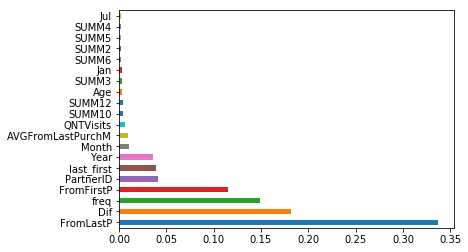

In [38]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [39]:
print(roc_auc_score(y2, model.predict(test2)))

0.9679082857591073


In [40]:
print(roc_auc_score(y2, model.predict_proba(test2)[:,1]))

0.9999968886938443


In [41]:
 pridict = model.predict_proba(pred)

In [100]:
pd.Series(pridict[:,1]).value_counts()

0.000000    488444
1.000000    486750
0.010000    148802
0.020000     88379
0.030000     63703
0.040000     53289
0.950000     47179
0.050000     45165
0.970000     43829
0.980000     43523
0.940000     43317
0.960000     42142
0.060000     31868
0.930000     31757
0.990000     30528
0.920000     24805
0.910000     22671
0.900000     21555
0.890000     19640
0.070000     19213
0.880000     18109
0.870000     16174
0.860000     14452
0.850000     13658
0.080000     12358
0.840000     12177
0.830000     11354
0.820000     11159
0.810000     10971
0.800000     10295
             ...  
0.404258        18
0.374258        18
0.324258        17
0.344258        17
0.364258        17
0.384258        17
0.354258        16
0.334258        12
0.284258        12
0.274258        12
0.264258        11
0.224258        11
0.294258        10
0.304258        10
0.254258        10
0.114258         9
0.394258         8
0.134258         7
0.244258         7
0.314258         5
0.174258         5
0.124258    

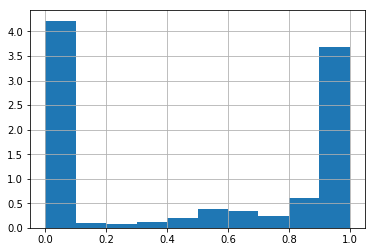

In [106]:
pd.Series(pridict[:,1]).hist(normed=True)

In [76]:
predId[:5]

0    1459710
1    1519442
2    1631246
3    2093789
4    2093403
Name: PartnerID, dtype: int64

In [68]:
print(type(predId))
print(type(pridict))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [80]:
pred_ottok = pd.concat([predId,pd.Series(pridict[:,1])],axis=1)

In [81]:
pred_ottok.to_csv('ottok.csv')

In [83]:
pred_ottok2 = pd.concat([pred2,pd.Series(pridict[:,1])],axis=1)

In [87]:
pred_ottok2.columns.values

array(['Period', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec', 'FromLastP', 'FromFirstP',
       'VisitInCurrentMonth', 'BudetVisit', 'PartnerID', 'Sex', 'Age',
       'AVGFromLastPurchM', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4',
       'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11',
       'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k',
       'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'LastP', 'Dif', 'ottok', 'CityID_2',
       'CityID_3', 'CityID_4', 'CityID_5', 'CityID_6', 'CityID_7',
       'CityID_9', 'CityID_10', 'CityID_11', 'CityID_12', 'CityID_13',
       'CityID_14', 'CityID_15', 'CityID_16', 'CityID_17', 'CityID_18',
       'CityID_19', 'CityID_20', 'CityID_21', 'CityID_22', 'CityID_23',
       'CityID_24', 'CityI

In [88]:
pred_ottok2.drop(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Okt', 'Nov', 'Dec','ottok', 'CityID_2',
       'CityID_3', 'CityID_4', 'CityID_5', 'CityID_6', 'CityID_7',
       'CityID_9', 'CityID_10', 'CityID_11', 'CityID_12', 'CityID_13',
       'CityID_14', 'CityID_15', 'CityID_16', 'CityID_17', 'CityID_18',
       'CityID_19', 'CityID_20', 'CityID_21', 'CityID_22', 'CityID_23',
       'CityID_24', 'CityID_25', 'CityID_26', 'CityID_27', 'CityID_28',
       'CityID_29', 'CityID_30', 'CityID_31', 'CityID_32', 'CityID_34',
       'CityID_35', 'CityID_36', 'CityID_37', 'CityID_38', 'CityID_39',
       'CityID_40', 'CityID_41', 'CityID_42', 'CityID_43', 'CityID_44',
       'CityID_45', 'CityID_46', 'CityID_47', 'CityID_48', 'CityID_49',
       'CityID_50', 'CityID_51', 'CityID_52', 'CityID_53', 'CityID_56',
       'CityID_58', 'CityID_59', 'CityID_60', 'CityID_61', 'CityID_62',
       'CityID_63', 'CityID_64', 'CityID_65', 'CityID_66', 'CityID_67',
       'CityID_68', 'CityID_69', 'CityID_70', 'CityID_72', 'CityID_74',
       'CityID_75', 'CityID_76', 'CityID_77', 'CityID_78', 'CityID_79',
       'CityID_80', 'CityID_81', 'CityID_82', 'CityID_83', 'CityID_84',
       'CityID_85', 'CityID_89', 'CityID_90', 'CityID_91', 'CityID_92',
       'CityID_93', 'CityID_94', 'CityID_95', 'CityID_96', 'CityID_97',
       'CityID_98', 'CityID_99', 'CityID_101', 'CityID_102', 'CityID_103',
       'CityID_104', 'CityID_105', 'CityID_106', 'CityID_107',
       'CityID_108', 'CityID_109', 'CityID_110', 'CityID_112',
       'CityID_114', 'CityID_115', 'CityID_116', 'CityID_117',
       'CityID_118', 'CityID_119', 'CityID_120', 'CityID_121',
       'CityID_122', 'CityID_123', 'CityID_124', 'CityID_125',
       'CityID_126', 'CityID_127', 'CityID_128',],axis=1,inplace=True)

In [92]:
pred_ottok2.head()

,Period,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,0
0,2018-11-01,36.2,51.933333,0,0,1459710,0,25,5.200000,6,0,6,16238.0,3169.2,0,0,0,0,0,2,2,0,0,0,2,0,2,1,2,1,0,0,2,3,0,1,0,2,1,0,3,4,2,1,1099,1.0
1,2018-11-01,36.2,46.833333,0,0,1519442,1,40,3.400000,7,0,9,40066.0,7845.0,0,0,1,0,0,0,1,2,0,3,1,3,0,3,3,3,0,3,4,0,1,1,0,1,1,0,7,9,0,1,1099,1.0
2,2018-11-01,36.2,44.166666,0,0,1631246,0,26,7.966666,2,0,2,1457.0,728.5,0,0,1,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,2,1,1099,1.0
3,2018-11-01,36.2,36.200000,0,0,2093789,1,26,0.000000,1,0,1,32680.0,32680.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1099,1.0
4,2018-11-01,36.2,36.200000,0,0,2093403,1,41,0.000000,1,0,2,6059.0,6059.0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,2,2,0,1,1099,1.0


In [93]:
pred_ottok2.tail()

,Period,FromLastP,FromFirstP,VisitInCurrentMonth,BudetVisit,PartnerID,Sex,Age,AVGFromLastPurchM,QNTVisits,SumSMS,SumQuantity,SumSumma,AVGSumma,SUMM1,SUMM2,SUMM3,SUMM4,SUMM5,SUMM6,SUMM7,SUMM8,SUMM9,SUMM10,SUMM11,SUMM12,SUMP1k,SUMP3k,SUMP6k,SUMP12k,SUMP50k,SUMKolco,SUMSERGI,SUMPODVES,SUMCEP,SUMBRASLET,SUMKOLE,SUMCheap,SUMExpensive,SUMPremium,SUMMiddle,SUMZoloto,SUMSerebro,LastP,Dif,0
2281359,2018-11-01,0.133333,2.766666,0,0,3177223,0,35,2.633333,2,0,3,1251.5,625.750000,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,2,0,0,1,0,3,1,17,0.0
2281360,2018-11-01,0.133333,0.133333,0,0,2774085,0,39,0.000000,1,0,6,4836.0,4836.000000,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,2,0,1,1,2,0,1,3,0,2,0,6,1,17,0.0
2281361,2018-11-01,0.133333,34.233333,0,0,2302444,0,23,17.033333,3,0,4,46267.0,15422.333333,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,2,1,3,0,0,1,0,0,0,3,0,1,4,0,1,17,0.0
2281362,2018-11-01,0.133333,0.133333,0,0,5362279,1,27,0.000000,1,0,2,8884.0,8884.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,2,0,0,0,2,1,17,0.0
2281363,2018-11-01,0.133333,11.566666,0,0,5364538,0,44,5.700000,3,1,7,34320.0,17429.000000,0,0,0,0,0,0,0,0,0,2,4,2,0,1,5,1,0,2,3,1,0,1,0,0,3,0,4,7,0,1,17,0.0


In [42]:
import pickle
output = open('OTTOK'+'.pkl','wb')
pickle.dump(model, output, 2)
output.close()

In [179]:
from catboost import CatBoostClassifier
from catboost import Pool

#cat_features = []
train_data = X_train
train_labels = y_train
test_data = X_test

p = Pool(X_train, y_train ) #,cat_features=cat_features)

model = CatBoostClassifier(iterations=1000, learning_rate=0.5, depth=9, loss_function='Logloss',silent=False,n)

model.fit(p)
# Прогноз класса
preds_class = model.predict(test_data)
# Прогноз вероятности каждого класса
preds_proba = model.predict_proba(test_data)

# Проверка модели
print(metrics.classification_report(y_test, preds_class))
print(metrics.confusion_matrix(y_test, preds_class))
print(roc_auc_score(y_test, preds_class))

Exception ignored in: <module 'collections.abc' from 'C:\\ProgramData\\Anaconda3\\lib\\collections\\abc.py'>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
KeyboardInterrupt


0:	learn: 0.4460409	total: 5.79s	remaining: 3h 12m 50s
1:	learn: 0.4016987	total: 11.4s	remaining: 3h 10m 6s
2:	learn: 0.3902969	total: 17.1s	remaining: 3h 9m 34s
3:	learn: 0.3863174	total: 22.8s	remaining: 3h 9m 27s
4:	learn: 0.3839740	total: 28.4s	remaining: 3h 8m 59s
5:	learn: 0.3821684	total: 34.2s	remaining: 3h 9m 13s
6:	learn: 0.3811178	total: 39.9s	remaining: 3h 9m 8s
7:	learn: 0.3802488	total: 45.5s	remaining: 3h 9m
8:	learn: 0.3797004	total: 51.2s	remaining: 3h 8m 55s
9:	learn: 0.3792945	total: 57s	remaining: 3h 9m 3s
10:	learn: 0.3787292	total: 1m 2s	remaining: 3h 8m 48s
11:	learn: 0.3784248	total: 1m 8s	remaining: 3h 8m 45s
12:	learn: 0.3781459	total: 1m 14s	remaining: 3h 8m 42s
13:	learn: 0.3779423	total: 1m 19s	remaining: 3h 8m 31s
14:	learn: 0.3776425	total: 1m 25s	remaining: 3h 8m 19s
15:	learn: 0.3772850	total: 1m 31s	remaining: 3h 8m 15s
16:	learn: 0.3771538	total: 1m 36s	remaining: 3h 8m 28s
17:	learn: 0.3768798	total: 1m 42s	remaining: 3h 8m 21s
18:	learn: 0.3763804	

147:	learn: 0.3615229	total: 14m 4s	remaining: 2h 56m 4s
148:	learn: 0.3614171	total: 14m 9s	remaining: 2h 55m 58s
149:	learn: 0.3613176	total: 14m 15s	remaining: 2h 55m 52s
150:	learn: 0.3612551	total: 14m 21s	remaining: 2h 55m 46s
151:	learn: 0.3611575	total: 14m 27s	remaining: 2h 55m 41s
152:	learn: 0.3610034	total: 14m 32s	remaining: 2h 55m 36s
153:	learn: 0.3608989	total: 14m 38s	remaining: 2h 55m 30s
154:	learn: 0.3608234	total: 14m 44s	remaining: 2h 55m 27s
155:	learn: 0.3607118	total: 14m 50s	remaining: 2h 55m 21s
156:	learn: 0.3606422	total: 14m 55s	remaining: 2h 55m 14s
157:	learn: 0.3605466	total: 15m 1s	remaining: 2h 55m 8s
158:	learn: 0.3604460	total: 15m 7s	remaining: 2h 55m 2s
159:	learn: 0.3603752	total: 15m 12s	remaining: 2h 54m 56s
160:	learn: 0.3602881	total: 15m 18s	remaining: 2h 54m 50s
161:	learn: 0.3601883	total: 15m 24s	remaining: 2h 54m 45s
162:	learn: 0.3601353	total: 15m 29s	remaining: 2h 54m 39s
163:	learn: 0.3600541	total: 15m 35s	remaining: 2h 54m 33s
164:

287:	learn: 0.3488608	total: 27m 20s	remaining: 2h 42m 31s
288:	learn: 0.3487718	total: 27m 26s	remaining: 2h 42m 25s
289:	learn: 0.3487076	total: 27m 31s	remaining: 2h 42m 19s
290:	learn: 0.3486365	total: 27m 37s	remaining: 2h 42m 13s
291:	learn: 0.3485893	total: 27m 42s	remaining: 2h 42m 7s
292:	learn: 0.3485322	total: 27m 48s	remaining: 2h 42m 2s
293:	learn: 0.3484606	total: 27m 54s	remaining: 2h 41m 56s
294:	learn: 0.3483918	total: 28m	remaining: 2h 41m 51s
295:	learn: 0.3483373	total: 28m 5s	remaining: 2h 41m 45s
296:	learn: 0.3482582	total: 28m 11s	remaining: 2h 41m 39s
297:	learn: 0.3481812	total: 28m 17s	remaining: 2h 41m 33s
298:	learn: 0.3480998	total: 28m 22s	remaining: 2h 41m 28s
299:	learn: 0.3480059	total: 28m 28s	remaining: 2h 41m 22s
300:	learn: 0.3479587	total: 28m 34s	remaining: 2h 41m 16s
301:	learn: 0.3478618	total: 28m 39s	remaining: 2h 41m 10s
302:	learn: 0.3477644	total: 28m 45s	remaining: 2h 41m 4s
303:	learn: 0.3476947	total: 28m 51s	remaining: 2h 40m 58s
304:	

427:	learn: 0.3384451	total: 40m 36s	remaining: 2h 29m 7s
428:	learn: 0.3383820	total: 40m 41s	remaining: 2h 29m 2s
429:	learn: 0.3382976	total: 40m 47s	remaining: 2h 28m 56s
430:	learn: 0.3382202	total: 40m 53s	remaining: 2h 28m 50s
431:	learn: 0.3381733	total: 40m 58s	remaining: 2h 28m 44s
432:	learn: 0.3380774	total: 41m 4s	remaining: 2h 28m 39s
433:	learn: 0.3379954	total: 41m 10s	remaining: 2h 28m 33s
434:	learn: 0.3379057	total: 41m 15s	remaining: 2h 28m 27s
435:	learn: 0.3378473	total: 41m 21s	remaining: 2h 28m 21s
436:	learn: 0.3377566	total: 41m 27s	remaining: 2h 28m 16s
437:	learn: 0.3376892	total: 41m 32s	remaining: 2h 28m 10s
438:	learn: 0.3376160	total: 41m 38s	remaining: 2h 28m 4s
439:	learn: 0.3375380	total: 41m 44s	remaining: 2h 27m 58s
440:	learn: 0.3374546	total: 41m 49s	remaining: 2h 27m 53s
441:	learn: 0.3373457	total: 41m 55s	remaining: 2h 27m 47s
442:	learn: 0.3372780	total: 42m 1s	remaining: 2h 27m 42s
443:	learn: 0.3371838	total: 42m 7s	remaining: 2h 27m 36s
444

567:	learn: 0.3283166	total: 53m 52s	remaining: 2h 15m 48s
568:	learn: 0.3282297	total: 53m 57s	remaining: 2h 15m 42s
569:	learn: 0.3281575	total: 54m 3s	remaining: 2h 15m 37s
570:	learn: 0.3280689	total: 54m 9s	remaining: 2h 15m 31s
571:	learn: 0.3279531	total: 54m 14s	remaining: 2h 15m 25s
572:	learn: 0.3279157	total: 54m 20s	remaining: 2h 15m 20s
573:	learn: 0.3278685	total: 54m 26s	remaining: 2h 15m 14s
574:	learn: 0.3278206	total: 54m 31s	remaining: 2h 15m 8s
575:	learn: 0.3277209	total: 54m 37s	remaining: 2h 15m 3s
576:	learn: 0.3276577	total: 54m 43s	remaining: 2h 14m 57s
577:	learn: 0.3275783	total: 54m 49s	remaining: 2h 14m 51s
578:	learn: 0.3275386	total: 54m 54s	remaining: 2h 14m 46s
579:	learn: 0.3274727	total: 55m	remaining: 2h 14m 40s
580:	learn: 0.3273870	total: 55m 6s	remaining: 2h 14m 34s
581:	learn: 0.3273270	total: 55m 11s	remaining: 2h 14m 29s
582:	learn: 0.3272710	total: 55m 17s	remaining: 2h 14m 23s
583:	learn: 0.3271790	total: 55m 23s	remaining: 2h 14m 17s
584:	l

707:	learn: 0.3188937	total: 1h 7m 8s	remaining: 2h 2m 30s
708:	learn: 0.3188103	total: 1h 7m 13s	remaining: 2h 2m 25s
709:	learn: 0.3187529	total: 1h 7m 19s	remaining: 2h 2m 19s
710:	learn: 0.3186938	total: 1h 7m 25s	remaining: 2h 2m 13s
711:	learn: 0.3186203	total: 1h 7m 30s	remaining: 2h 2m 8s
712:	learn: 0.3185604	total: 1h 7m 36s	remaining: 2h 2m 2s
713:	learn: 0.3184965	total: 1h 7m 42s	remaining: 2h 1m 56s
714:	learn: 0.3184574	total: 1h 7m 47s	remaining: 2h 1m 50s
715:	learn: 0.3183833	total: 1h 7m 53s	remaining: 2h 1m 45s
716:	learn: 0.3183431	total: 1h 7m 59s	remaining: 2h 1m 39s
717:	learn: 0.3182996	total: 1h 8m 5s	remaining: 2h 1m 33s
718:	learn: 0.3182484	total: 1h 8m 10s	remaining: 2h 1m 28s
719:	learn: 0.3181928	total: 1h 8m 16s	remaining: 2h 1m 22s
720:	learn: 0.3181036	total: 1h 8m 21s	remaining: 2h 1m 16s
721:	learn: 0.3180274	total: 1h 8m 27s	remaining: 2h 1m 10s
722:	learn: 0.3179430	total: 1h 8m 33s	remaining: 2h 1m 5s
723:	learn: 0.3178630	total: 1h 8m 38s	remain

842:	learn: 0.3100954	total: 1h 19m 55s	remaining: 1h 49m 41s
843:	learn: 0.3100403	total: 1h 20m	remaining: 1h 49m 35s
844:	learn: 0.3099606	total: 1h 20m 6s	remaining: 1h 49m 29s
845:	learn: 0.3098837	total: 1h 20m 12s	remaining: 1h 49m 24s
846:	learn: 0.3098093	total: 1h 20m 18s	remaining: 1h 49m 18s
847:	learn: 0.3097723	total: 1h 20m 23s	remaining: 1h 49m 12s
848:	learn: 0.3097389	total: 1h 20m 29s	remaining: 1h 49m 7s
849:	learn: 0.3096840	total: 1h 20m 35s	remaining: 1h 49m 1s
850:	learn: 0.3096107	total: 1h 20m 40s	remaining: 1h 48m 55s
851:	learn: 0.3095258	total: 1h 20m 46s	remaining: 1h 48m 50s
852:	learn: 0.3094577	total: 1h 20m 52s	remaining: 1h 48m 44s
853:	learn: 0.3093646	total: 1h 20m 57s	remaining: 1h 48m 38s
854:	learn: 0.3093114	total: 1h 21m 3s	remaining: 1h 48m 32s
855:	learn: 0.3092555	total: 1h 21m 9s	remaining: 1h 48m 27s
856:	learn: 0.3091559	total: 1h 21m 14s	remaining: 1h 48m 21s
857:	learn: 0.3091050	total: 1h 21m 20s	remaining: 1h 48m 16s
858:	learn: 0.309

976:	learn: 0.3020439	total: 1h 32m 36s	remaining: 1h 36m 57s
977:	learn: 0.3019899	total: 1h 32m 41s	remaining: 1h 36m 52s
978:	learn: 0.3019284	total: 1h 32m 47s	remaining: 1h 36m 46s
979:	learn: 0.3018816	total: 1h 32m 53s	remaining: 1h 36m 40s
980:	learn: 0.3018175	total: 1h 32m 58s	remaining: 1h 36m 34s
981:	learn: 0.3017208	total: 1h 33m 4s	remaining: 1h 36m 29s
982:	learn: 0.3016528	total: 1h 33m 10s	remaining: 1h 36m 23s
983:	learn: 0.3015961	total: 1h 33m 16s	remaining: 1h 36m 18s
984:	learn: 0.3015572	total: 1h 33m 21s	remaining: 1h 36m 12s
985:	learn: 0.3015150	total: 1h 33m 27s	remaining: 1h 36m 6s
986:	learn: 0.3014739	total: 1h 33m 33s	remaining: 1h 36m 1s
987:	learn: 0.3014244	total: 1h 33m 38s	remaining: 1h 35m 55s
988:	learn: 0.3013819	total: 1h 33m 44s	remaining: 1h 35m 49s
989:	learn: 0.3013575	total: 1h 33m 50s	remaining: 1h 35m 43s
990:	learn: 0.3013264	total: 1h 33m 55s	remaining: 1h 35m 38s
991:	learn: 0.3012858	total: 1h 34m 1s	remaining: 1h 35m 32s
992:	learn: 

1108:	learn: 0.2947030	total: 1h 45m 6s	remaining: 1h 24m 26s
1109:	learn: 0.2946376	total: 1h 45m 12s	remaining: 1h 24m 21s
1110:	learn: 0.2945910	total: 1h 45m 17s	remaining: 1h 24m 15s
1111:	learn: 0.2945346	total: 1h 45m 23s	remaining: 1h 24m 9s
1112:	learn: 0.2944657	total: 1h 45m 29s	remaining: 1h 24m 4s
1113:	learn: 0.2944150	total: 1h 45m 34s	remaining: 1h 23m 58s
1114:	learn: 0.2943495	total: 1h 45m 40s	remaining: 1h 23m 52s
1115:	learn: 0.2943008	total: 1h 45m 46s	remaining: 1h 23m 46s
1116:	learn: 0.2942563	total: 1h 45m 51s	remaining: 1h 23m 41s
1117:	learn: 0.2941838	total: 1h 45m 57s	remaining: 1h 23m 35s
1118:	learn: 0.2941044	total: 1h 46m 3s	remaining: 1h 23m 29s
1119:	learn: 0.2940394	total: 1h 46m 8s	remaining: 1h 23m 24s
1120:	learn: 0.2939820	total: 1h 46m 14s	remaining: 1h 23m 18s
1121:	learn: 0.2939242	total: 1h 46m 20s	remaining: 1h 23m 12s
1122:	learn: 0.2938655	total: 1h 46m 26s	remaining: 1h 23m 7s
1123:	learn: 0.2938230	total: 1h 46m 31s	remaining: 1h 23m 1s

1239:	learn: 0.2872870	total: 1h 57m 30s	remaining: 1h 12m 1s
1240:	learn: 0.2872509	total: 1h 57m 35s	remaining: 1h 11m 55s
1241:	learn: 0.2872081	total: 1h 57m 41s	remaining: 1h 11m 49s
1242:	learn: 0.2871845	total: 1h 57m 47s	remaining: 1h 11m 44s
1243:	learn: 0.2871594	total: 1h 57m 52s	remaining: 1h 11m 38s
1244:	learn: 0.2870802	total: 1h 57m 58s	remaining: 1h 11m 32s
1245:	learn: 0.2870340	total: 1h 58m 4s	remaining: 1h 11m 26s
1246:	learn: 0.2869811	total: 1h 58m 9s	remaining: 1h 11m 21s
1247:	learn: 0.2869369	total: 1h 58m 15s	remaining: 1h 11m 15s
1248:	learn: 0.2868692	total: 1h 58m 21s	remaining: 1h 11m 9s
1249:	learn: 0.2868185	total: 1h 58m 27s	remaining: 1h 11m 4s
1250:	learn: 0.2867804	total: 1h 58m 32s	remaining: 1h 10m 58s
1251:	learn: 0.2867349	total: 1h 58m 38s	remaining: 1h 10m 52s
1252:	learn: 0.2867039	total: 1h 58m 44s	remaining: 1h 10m 47s
1253:	learn: 0.2866659	total: 1h 58m 49s	remaining: 1h 10m 41s
1254:	learn: 0.2866066	total: 1h 58m 55s	remaining: 1h 10m 3

1375:	learn: 0.2801730	total: 2h 10m 23s	remaining: 59m 7s
1376:	learn: 0.2801269	total: 2h 10m 28s	remaining: 59m 1s
1377:	learn: 0.2800721	total: 2h 10m 34s	remaining: 58m 56s
1378:	learn: 0.2800384	total: 2h 10m 40s	remaining: 58m 50s
1379:	learn: 0.2799745	total: 2h 10m 45s	remaining: 58m 44s
1380:	learn: 0.2799124	total: 2h 10m 51s	remaining: 58m 39s
1381:	learn: 0.2798769	total: 2h 10m 57s	remaining: 58m 33s
1382:	learn: 0.2798332	total: 2h 11m 2s	remaining: 58m 27s
1383:	learn: 0.2797793	total: 2h 11m 8s	remaining: 58m 22s
1384:	learn: 0.2797129	total: 2h 11m 14s	remaining: 58m 16s
1385:	learn: 0.2796560	total: 2h 11m 19s	remaining: 58m 10s
1386:	learn: 0.2795789	total: 2h 11m 25s	remaining: 58m 5s
1387:	learn: 0.2795292	total: 2h 11m 31s	remaining: 57m 59s
1388:	learn: 0.2794858	total: 2h 11m 36s	remaining: 57m 53s
1389:	learn: 0.2794227	total: 2h 11m 42s	remaining: 57m 48s
1390:	learn: 0.2793771	total: 2h 11m 48s	remaining: 57m 42s
1391:	learn: 0.2793123	total: 2h 11m 53s	rema

1513:	learn: 0.2732481	total: 2h 23m 26s	remaining: 46m 2s
1514:	learn: 0.2732018	total: 2h 23m 32s	remaining: 45m 57s
1515:	learn: 0.2731584	total: 2h 23m 37s	remaining: 45m 51s
1516:	learn: 0.2731158	total: 2h 23m 43s	remaining: 45m 45s
1517:	learn: 0.2730774	total: 2h 23m 49s	remaining: 45m 39s
1518:	learn: 0.2730031	total: 2h 23m 54s	remaining: 45m 34s
1519:	learn: 0.2729769	total: 2h 24m	remaining: 45m 28s
1520:	learn: 0.2729235	total: 2h 24m 6s	remaining: 45m 22s
1521:	learn: 0.2728600	total: 2h 24m 11s	remaining: 45m 17s
1522:	learn: 0.2727989	total: 2h 24m 17s	remaining: 45m 11s
1523:	learn: 0.2727728	total: 2h 24m 23s	remaining: 45m 5s
1524:	learn: 0.2727103	total: 2h 24m 29s	remaining: 45m
1525:	learn: 0.2726701	total: 2h 24m 34s	remaining: 44m 54s
1526:	learn: 0.2726066	total: 2h 24m 40s	remaining: 44m 48s
1527:	learn: 0.2725595	total: 2h 24m 46s	remaining: 44m 43s
1528:	learn: 0.2725111	total: 2h 24m 51s	remaining: 44m 37s
1529:	learn: 0.2724642	total: 2h 24m 57s	remaining:

1651:	learn: 0.2662965	total: 2h 36m 29s	remaining: 32m 57s
1652:	learn: 0.2662646	total: 2h 36m 35s	remaining: 32m 52s
1653:	learn: 0.2662057	total: 2h 36m 40s	remaining: 32m 46s
1654:	learn: 0.2661614	total: 2h 36m 46s	remaining: 32m 40s
1655:	learn: 0.2661424	total: 2h 36m 52s	remaining: 32m 35s
1656:	learn: 0.2660860	total: 2h 36m 57s	remaining: 32m 29s
1657:	learn: 0.2660504	total: 2h 37m 3s	remaining: 32m 23s
1658:	learn: 0.2659923	total: 2h 37m 9s	remaining: 32m 18s
1659:	learn: 0.2659401	total: 2h 37m 14s	remaining: 32m 12s
1660:	learn: 0.2658924	total: 2h 37m 20s	remaining: 32m 6s
1661:	learn: 0.2658314	total: 2h 37m 26s	remaining: 32m 1s
1662:	learn: 0.2657763	total: 2h 37m 31s	remaining: 31m 55s
1663:	learn: 0.2657608	total: 2h 37m 37s	remaining: 31m 49s
1664:	learn: 0.2657185	total: 2h 37m 43s	remaining: 31m 44s
1665:	learn: 0.2656530	total: 2h 37m 49s	remaining: 31m 38s
1666:	learn: 0.2656139	total: 2h 37m 54s	remaining: 31m 32s
1667:	learn: 0.2655887	total: 2h 38m	remaini

1789:	learn: 0.2599241	total: 2h 49m 33s	remaining: 19m 53s
1790:	learn: 0.2598480	total: 2h 49m 38s	remaining: 19m 47s
1791:	learn: 0.2598156	total: 2h 49m 44s	remaining: 19m 42s
1792:	learn: 0.2597722	total: 2h 49m 50s	remaining: 19m 36s
1793:	learn: 0.2597185	total: 2h 49m 55s	remaining: 19m 30s
1794:	learn: 0.2596918	total: 2h 50m 1s	remaining: 19m 25s
1795:	learn: 0.2596589	total: 2h 50m 7s	remaining: 19m 19s
1796:	learn: 0.2596208	total: 2h 50m 13s	remaining: 19m 13s
1797:	learn: 0.2595740	total: 2h 50m 18s	remaining: 19m 8s
1798:	learn: 0.2595218	total: 2h 50m 24s	remaining: 19m 2s
1799:	learn: 0.2594780	total: 2h 50m 29s	remaining: 18m 56s
1800:	learn: 0.2593997	total: 2h 50m 35s	remaining: 18m 50s
1801:	learn: 0.2593588	total: 2h 50m 41s	remaining: 18m 45s
1802:	learn: 0.2593075	total: 2h 50m 47s	remaining: 18m 39s
1803:	learn: 0.2592857	total: 2h 50m 52s	remaining: 18m 33s
1804:	learn: 0.2592410	total: 2h 50m 58s	remaining: 18m 28s
1805:	learn: 0.2591747	total: 2h 51m 4s	rema

1929:	learn: 0.2533555	total: 3h 2m 48s	remaining: 6m 37s
1930:	learn: 0.2533003	total: 3h 2m 53s	remaining: 6m 32s
1931:	learn: 0.2532677	total: 3h 2m 59s	remaining: 6m 26s
1932:	learn: 0.2532218	total: 3h 3m 5s	remaining: 6m 20s
1933:	learn: 0.2532071	total: 3h 3m 10s	remaining: 6m 15s
1934:	learn: 0.2531480	total: 3h 3m 16s	remaining: 6m 9s
1935:	learn: 0.2530936	total: 3h 3m 22s	remaining: 6m 3s
1936:	learn: 0.2530265	total: 3h 3m 27s	remaining: 5m 58s
1937:	learn: 0.2529871	total: 3h 3m 33s	remaining: 5m 52s
1938:	learn: 0.2529674	total: 3h 3m 39s	remaining: 5m 46s
1939:	learn: 0.2529184	total: 3h 3m 45s	remaining: 5m 40s
1940:	learn: 0.2528853	total: 3h 3m 50s	remaining: 5m 35s
1941:	learn: 0.2528568	total: 3h 3m 56s	remaining: 5m 29s
1942:	learn: 0.2528080	total: 3h 4m 2s	remaining: 5m 23s
1943:	learn: 0.2527755	total: 3h 4m 7s	remaining: 5m 18s
1944:	learn: 0.2527394	total: 3h 4m 13s	remaining: 5m 12s
1945:	learn: 0.2527098	total: 3h 4m 19s	remaining: 5m 6s
1946:	learn: 0.25267

In [182]:
2+2

4

0.5920481208347544
